# CNN_mat
*this notebook will implement deep learning on the preprocessed svhn data and train a model that can recognize house number*

In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle
import tensorflow as tf
from sklearn import linear_model as lr
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# unpack the data from files
def unpickle(file_name):
    print("loading %s" %file_name)
    try:
        with open(file_name, "rb") as f:
            data = pickle.load(f)
            print("SUCCESS!")
            return data['X'].astype(np.float32), data['y'].astype(np.float32)
    except Exception as e:
        print("FAILED: ", e)
        

In [3]:
train_X, train_y = unpickle("train.pickle")
print(train_X.shape, train_y.shape)
val_X, val_y = unpickle("validation.pickle")
print(val_X.shape, val_y.shape)
test_X, test_y = unpickle("test.pickle")
print(test_X.shape, test_y.shape)

loading train.pickle
SUCCESS!
(100000, 32, 32) (100000,)
loading validation.pickle
SUCCESS!
(6000, 32, 32) (6000,)
loading test.pickle
SUCCESS!
(26032, 32, 32) (26032,)


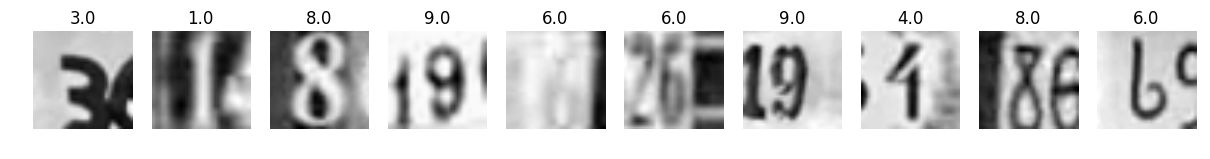

In [4]:
# display some images
def sample_display(X, y, random_idc = None):
    plt.rcParams["figure.figsize"] = (15.0, 15.0)
    f, ax = plt.subplots(nrows = 1, ncols = 10)
    if random_idc is None:
        random_idc = np.random.randint(0, X.shape[0], 10)
    for i, j in enumerate(random_idc):
        ax[i].axis('off')
        ax[i].set_title(y[j], loc = 'center')
        ax[i].imshow(X[j], cmap = 'gray')
        
sample_display(train_X, train_y)

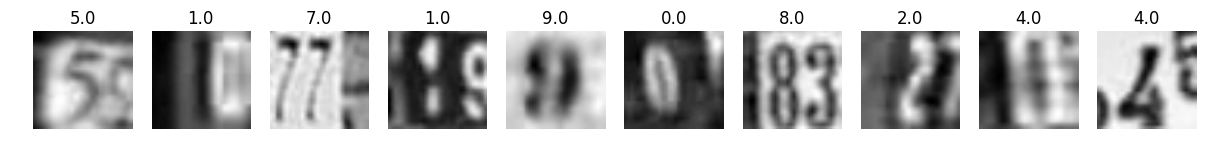

In [5]:
sample_display(val_X, val_y)

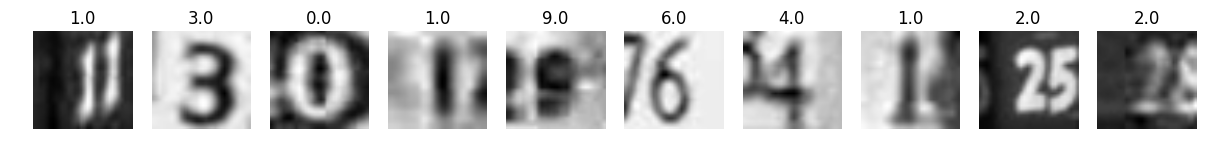

In [6]:
sample_display(test_X, test_y)

In [7]:
# before do a heavy cnn, it's better to check how a sgdclassifier perform
def no_nn():
    clf = lr.SGDClassifier(penalty = 'l2', n_iter=80)
    clf.fit(train_X.reshape([train_X.shape[0], train_X.shape[1]*train_X.shape[2]]), train_y)
    pred = clf.predict(test_X.reshape([test_X.shape[0], test_X.shape[1]*test_X.shape[2]]))
    confusion = metrics.confusion_matrix(test_y, pred)
    print(confusion)
    print(sum(test_y==pred)/float(test_y.shape[0]))

In [8]:
#no_nn()

*the next cell will build a computational graph for cnn*

In [9]:
# before building the graph, reshape the image
imsize = 32
train_X = train_X.reshape([-1, imsize, imsize, 1])
test_X = test_X.reshape([-1, imsize, imsize, 1])
val_X = val_X.reshape([-1, imsize, imsize, 1])
print(train_X.shape)
print(test_X.shape)
print(val_X.shape)

(100000, 32, 32, 1)
(26032, 32, 32, 1)
(6000, 32, 32, 1)


In [10]:
# ohe the y
num_labels = 10
num_channels = 1
def ohe(y):
    y = y.reshape([-1, 1])
    return (np.arange(num_labels) == y).astype(np.float32)
train_y = ohe(train_y)
test_y = ohe(test_y)
val_y = ohe(val_y)

In [11]:
def accuracy(pred, y):
    return 100.0 * np.sum(np.argmax(y, axis = 1) == np.argmax(pred, axis = 1))/float(y.shape[0])

In [27]:
batch_size = 256
patch_size = 5
depth = [32, 32]
num_hidden = 128

graph = tf.Graph()

with graph.as_default(): # conv-conv-conv-pool-fc-fc-out
    # Input data
    net_train_X = tf.placeholder(tf.float32, shape = (batch_size, imsize, imsize, num_channels))
    net_train_y = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    net_val_X = tf.constant(val_X)
    net_test_X = tf.constant(test_X)
    
    # Variables
    # f for filter, b for bias
    f1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth[0]], stddev = 0.01))
    b1 = tf.Variable(tf.zeros([depth[0]]))
    
    f2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth[0], depth[1]], stddev = 0.01))
    b2 = tf.Variable(tf.zeros([depth[1]]))
    
   
    fc1_w = tf.Variable(tf.truncated_normal([imsize//8*imsize//8*32, num_hidden], stddev = 0.3))
    fc1_b = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    
    fc2_w = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev = 0.3))
    fc2_b = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
 


    def model(data, drop = False): # conv-conv-pool-drop-fc-fc
    
        conv = tf.nn.conv2d(data, f1, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b1)
        dropped = tf.nn.dropout(relu, .5) if drop else relu
        
        conv = tf.nn.conv2d(dropped, f2, [1, 2, 2, 1], padding = 'SAME')
        relu = tf.nn.relu(conv + b2)
        pool = tf.nn.max_pool(relu, [1, 2, 2, 1], [1, 2, 2, 1], padding = 'SAME')
                 
        ## started to fc
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_w)) + fc1_b
        return tf.matmul(hidden, fc2_w) + fc2_b

    logits = model(net_train_X, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, net_train_y))

    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-2, global_step, 500, .88)

    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
    train_pred = tf.nn.softmax(model(net_train_X))
    val_pred = tf.nn.softmax(model(net_val_X))
    test_pred = tf.nn.softmax(model(net_test_X))


*the next cell will run the graph in a tensorflow session*

In [29]:
num_steps = 10001
log_steps = 500
log = {'val_acc':[], 'test_acc': 0.00}
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print('Initialize') 
    for step in range(num_steps):
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        batch_X = train_X[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size)]
        
        feed_dict = {net_train_X : batch_X, net_train_y : batch_y}
        
        _, stage_loss, pred = session.run([optimizer, loss, train_pred], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, stage_loss))
            print('Minibatch accuracy: %.1f%%' % accuracy(pred, batch_y))
            val_acc = accuracy(val_pred.eval(), val_y)
            print('Validation accuracy: %.1f%%' % val_acc)
            log['val_acc'].append(val_acc)
            
    test_acc = accuracy(test_pred.eval(), test_y)        
    print('Test accuracy: %.1f%%' % test_acc)
    log['test_acc'] = test_acc

Initialize
Minibatch loss at step 0: 5.201037
Minibatch accuracy: 9.4%
Validation accuracy: 10.0%
Minibatch loss at step 500: 0.668652
Minibatch accuracy: 80.1%
Validation accuracy: 82.7%
Minibatch loss at step 1000: 0.465596
Minibatch accuracy: 89.8%
Validation accuracy: 86.1%
Minibatch loss at step 1500: 0.283590
Minibatch accuracy: 92.2%
Validation accuracy: 87.6%
Minibatch loss at step 2000: 0.695162
Minibatch accuracy: 80.5%
Validation accuracy: 88.3%
Minibatch loss at step 2500: 0.668410
Minibatch accuracy: 84.8%
Validation accuracy: 88.2%
Minibatch loss at step 3000: 0.276416
Minibatch accuracy: 94.1%
Validation accuracy: 89.1%
Minibatch loss at step 3500: 0.133078
Minibatch accuracy: 96.5%
Validation accuracy: 89.6%
Minibatch loss at step 4000: 0.427908
Minibatch accuracy: 88.7%
Validation accuracy: 90.2%
Minibatch loss at step 4500: 0.150722
Minibatch accuracy: 97.7%
Validation accuracy: 90.4%
Minibatch loss at step 5000: 0.199902
Minibatch accuracy: 94.9%
Validation accuracy:

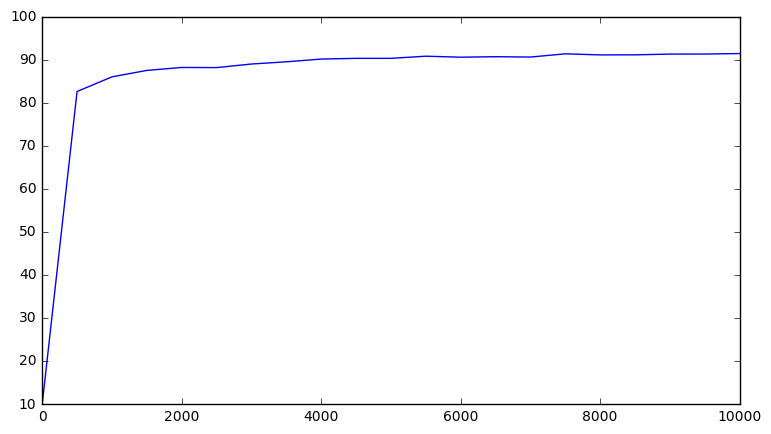

In [39]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.plot(log_steps*np.arange(len(log['val_acc'])), log['val_acc'])